In [1]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/MyDrive/"
!unzip "/content/drive/MyDrive/dataset.zip"
%pip install pygad


ModuleNotFoundError: No module named 'google.colab'

In [1]:

import tensorflow as tf
import pygad as pg
import pygad.kerasga
import os
import numpy as np

imgDir = os.path.join('dataset', 'flowers')
binaryDir = os.path.join('binaryDataset')
imgSize = 100
batchSize = 32

In [58]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(binaryDir, image_size=(imgSize,imgSize), batch_size=batchSize)
numBatches = np.asarray(tf.data.experimental.cardinality(dataset))
testData = dataset.take(int(numBatches * 0.2))
trainData = dataset.skip(int(numBatches * 0.2))
yTrain = np.asarray([y for x,y in trainData.unbatch()])

Found 2055 files belonging to 2 classes.


In [59]:
# Build the keras model using the functional API.
input_layer = tf.keras.layers.Input(shape=(imgSize, imgSize, 3))
conv_layer1 = tf.keras.layers.Conv2D(filters=5,
                                             kernel_size=7,
                                             activation="relu")(input_layer)
max_pool1 = tf.keras.layers.MaxPooling2D(pool_size=(5,5),
                                                 strides=5)(conv_layer1)
conv_layer2 = tf.keras.layers.Conv2D(filters=3,
                                             kernel_size=3,
                                             activation="relu")(max_pool1)
flatten_layer  = tf.keras.layers.Flatten()(conv_layer2)
dense_layer = tf.keras.layers.Dense(15, activation="relu")(flatten_layer)
output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(dense_layer)
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# make model checkpoint to save weights
checkpoints = tf.keras.callbacks.ModelCheckpoint("verifyWeights", monitor="sparse_categorical_accuracy", save_best_only=True)

model.summary()
model.compile(loss='binary_crossentropy', metrics='accuracy', optimizer='adam')

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 94, 94, 5)         740       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 18, 18, 5)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 3)         138       
                                                                 
 flatten_3 (Flatten)         (None, 768)               0         
                                                                 
 dense_6 (Dense)             (None, 15)                11535     
                                                           

In [6]:
model.fit(trainData, epochs=5, callbacks=checkpoints)

Epoch 1/5
40/40 [==============================] - 3s 17ms/step - loss: 3.3932 - accuracy: 0.6271
Epoch 2/5
40/40 [==============================] - 1s 16ms/step - loss: 0.5140 - accuracy: 0.7506
Epoch 3/5
40/40 [==============================] - 1s 16ms/step - loss: 0.3860 - accuracy: 0.8351
Epoch 4/5
40/40 [==============================] - 1s 16ms/step - loss: 0.3221 - accuracy: 0.8390
Epoch 5/5
40/40 [==============================] - 1s 16ms/step - loss: 0.2988 - accuracy: 0.8653


In [8]:
model.evaluate(testData)

25/25 [==============================] - 1s 13ms/step - loss: 31.1097 - accuracy: 0.3512


[31.109697341918945, 0.3512499928474426]

In [37]:
print(yTrain.shape)

(1255,)


In [19]:
# make a kerasGA
myGA = pg.kerasga.KerasGA(model=model, num_solutions=10)

#try overtraining for a second
thisBatch = trainData.take(32)
xTrain = np.asarray([x for x,y in thisBatch])
yTrue = np.asarray([y for x,y in thisBatch])


# this is our fitness func
def fitFunc(solution, solutionIndx):
    print('in fitness func')
    weightsMatrix = pg.kerasga.model_weights_as_matrix(model=model, weights_vector=solution)
    model.set_weights(weights=weightsMatrix)
    preds = model.predict(trainData)
    binaryCE = tf.keras.losses.BinaryCrossentropy()
    fitness = 1.0 / (binaryCE(yTrain, preds).numpy() + 0.00000001)
    return fitness

# progress callback for GA
def genCallback(gaInstance):
    print(f'Generation = {gaInstance.generations_completed}')
    print(f'fitness = {gaInstance.best_solution()[1]}')

In [50]:
# now make a GA instance with our variables
numGen = 30
numParentsMating = 5
initPopulation = myGA.population_weights

gaInstance = pg.GA(num_generations=numGen,
                   num_parents_mating=numParentsMating,
                   initial_population=initPopulation,
                   fitness_func=fitFunc,
                   on_generation=genCallback)

in fitness func
in fitness func
in fitness func
in fitness func
in fitness func
in fitness func
in fitness func
in fitness func
in fitness func
in fitness func
in fitness func
in fitness func
in fitness func
in fitness func
in fitness func
Generation = 1
in fitness func
in fitness func
in fitness func
in fitness func
in fitness func
fitness = 0.16347671105669043
in fitness func
in fitness func
in fitness func
in fitness func
in fitness func
Generation = 2
in fitness func
in fitness func
in fitness func
in fitness func
in fitness func
fitness = 0.16347671105669043
in fitness func
in fitness func
in fitness func
in fitness func
in fitness func
Generation = 3
in fitness func
in fitness func
in fitness func
in fitness func
in fitness func
fitness = 0.17937376801632804
in fitness func
in fitness func
in fitness func
in fitness func
in fitness func
Generation = 4
in fitness func
in fitness func
in fitness func
in fitness func
in fitness func
fitness = 0.17888495078832567
in fitness func
in f

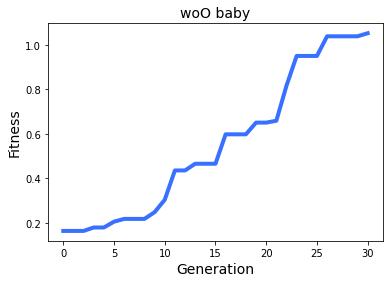

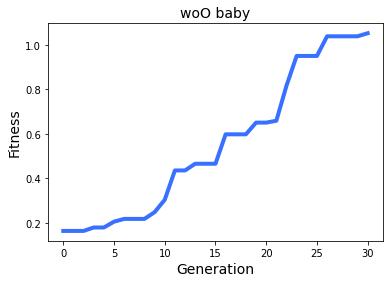

In [51]:
gaInstance.run()
fig = gaInstance.plot_fitness(title="woO baby", linewidth=4)

In [61]:

yTest = np.asarray([y for x,y in testData.unbatch()])
weightsMatrix = pg.kerasga.model_weights_as_matrix(model=model, weights_vector=gaInstance.best_solution()[0])
print(weightsMatrix)
model.set_weights(weights=weightsMatrix)
print(model.weights)
model.evaluate(testData)
preds = model.predict(testData)
binaryCE = tf.keras.losses.BinaryCrossentropy()
print(1 / binaryCE(yTest, preds).numpy())


in fitness func
in fitness func
in fitness func
in fitness func
in fitness func
[array([[[[-1.49086951,  0.62150173, -1.10910565, -0.95213532,
           1.30548094],
         [ 0.55444466, -0.10949986, -0.63894394, -0.50714752,
           0.90112492],
         [-0.0327686 , -0.1462329 , -0.03115408, -2.07180149,
           1.3245731 ]],

        [[-0.28469709,  0.91802469, -1.57596674,  1.12661088,
           2.10499502],
         [-1.07975109,  1.22053342, -0.54375481,  0.33503169,
           1.1574548 ],
         [-1.43683138, -0.23320936, -0.90819481, -0.52049681,
          -0.59535988]],

        [[ 1.22721594,  1.63394602,  1.50867563, -1.36046933,
           0.95765216],
         [-2.62896009, -0.36242306,  0.4796269 ,  0.33342842,
          -1.73766455],
         [ 1.25778181,  0.83563365, -0.39553979,  1.72551632,
          -0.91538804]],

        [[-0.32966275, -1.16789994,  1.07697835, -0.69088273,
           2.71284032],
         [ 2.48538158, -0.96367131,  0.12018767, -1.3

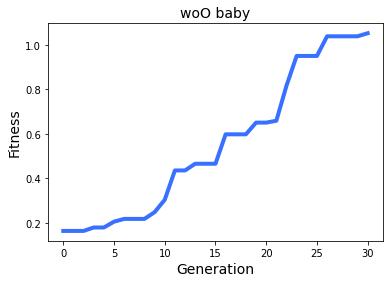

C:\Users\rbfre\AppData\Local\Temp\ipykernel_4804\2229258293.py:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fig" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(os.path.join("graphs", "graph"), fig = fig)


<Figure size 432x288 with 0 Axes>

In [63]:
import matplotlib.pyplot as plt

fig = gaInstance.plot_fitness(title="woO baby", linewidth=4)
plt.savefig(os.path.join("graphs", "graph"), fig = fig)